## Test a Pre-Trained Classifier

In [ ]:
from src.neuralnet import NeuralNetwork
import torch
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import sklearn.metrics
from time import time
import kagglehub
import os
import patoolib

First, download and extract dataset. Download and extraction may take a few minutes.

In [17]:
path = kagglehub.dataset_download("xainano/handwrittenmathsymbols")

# Extract .rar. Note that this requires unrar to be installed
# - sudo apt install unrar
patoolib.extract_archive(path + "/data.rar", outdir=path + "/data/")

INFO patool: Extracting /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar
INFO patool: ... /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar extracted to `/home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data/'.


'/home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data/'

In [24]:
DATA_PATH = f"{path}/data/extracted_images/"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "model.pth"
BATCH_SIZE = 64

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = NeuralNetwork().to(DEVICE)
model.load_state_dict(checkpoint['model_state'])
history = checkpoint['history']

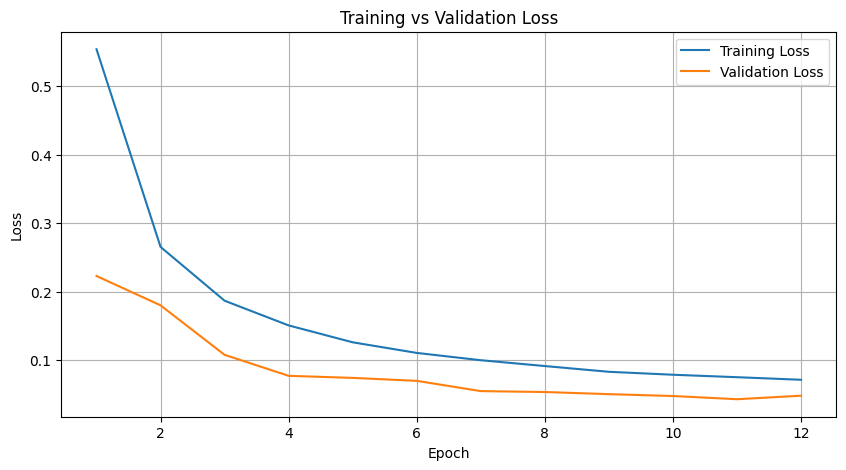

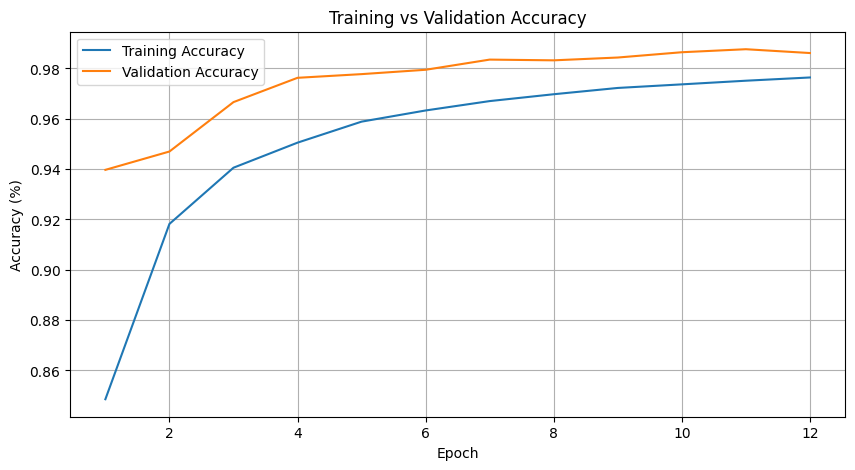

In [25]:
def plot_history(history):
    num_epochs = range(1, len(history['epoch_time']) + 1)

    # ============== Loss Plot ==============
    plt.figure(figsize=(10, 5))
    plt.plot(num_epochs, history['train_loss'], label='Training Loss')
    plt.plot(num_epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ============== Accuracy Plot ==============
    plt.figure(figsize=(10, 5))
    plt.plot(num_epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(num_epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)

In [ ]:
transformations = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale(),
    v2.Normalize((0.5,), (0.5,)) #Transform values [0, 1] -> [-1, 1] 
])

dataset = torchvision.datasets.ImageFolder(
    root=DATA_PATH,
    transform=transformations,
)

#Split dataset into train and test sets 80%-10%-10% train-validate-test split.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

#Load -> see https://docs.pytorch.org/docs/stable/data.html for performance tuning (i.e, num_workers > 0 and pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Visualize some of the testing data

There are 82 classes!


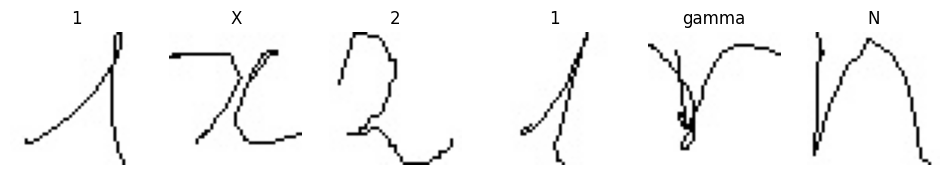

In [38]:
images, labels = next(iter(test_loader))
print(f"There are {len(os.listdir(DATA_PATH))} classes!")

fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    img = images[i].squeeze().numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(dataset.classes[labels[i]])
    axes[i].axis('off')

plt.show()

Evaluate the test data. Running the classifier on the testing dataset may take several minutes.

In [ ]:
model.to(DEVICE)
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

test_start = time()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Finished Testing in {(time() - test_start) / 60:.2f} minutes\n\t- Accuracy: {100 * correct / total:.2f}%")

Visualize symbol overlap with confusion matrices

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']


Text(0.5, 1.0, 'Confusion Matrix - Commonly Confused')

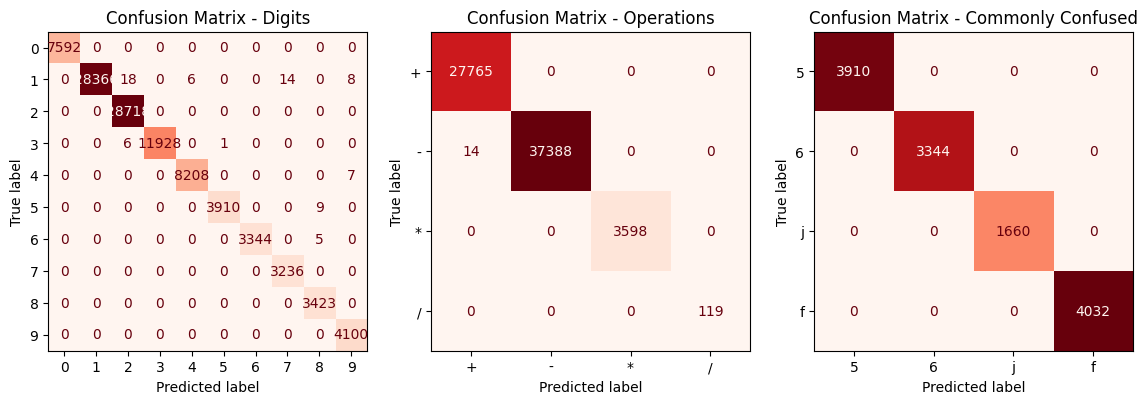

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_labels,
    y_pred=all_predictions,
    labels=range(6, 16),
    display_labels=range(10),
    colorbar=False,
    cmap="Reds",
    ax=axes[0],
);
axes[0].set_title("Confusion Matrix - Digits")

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_labels,
    y_pred=all_predictions,
    labels=(3, 5, 74, 41),
    display_labels=('+', '-', '*', '/'),
    colorbar=False,    
    cmap="Reds",
    ax=axes[1],
);
axes[1].set_title("Confusion Matrix - Operations")

print(dataset.classes)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_labels,
    y_pred=all_predictions,
    labels=(11, 12, 49, 39),
    display_labels=('5', '6', 'j', 'f'),
    colorbar=False,
    cmap="Reds",
    ax=axes[2],
);
axes[2].set_title("Confusion Matrix - Commonly Confused")